In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Финальный проект по курусу временные ряды
#Колчанов Н.М. фз-11
#
#Суть финального проекта заключается в прогнозировании мультивариативного ряда с использованием полученных во время прохождения курса знаний и навыков

#Описание датасета
#
#Эти наборы данных созданы для краткосрочного прогнозирования электроэнергии. 
#Эта проблема прогнозирования известна в исследовательской области как краткосрочное прогнозирование нагрузки (STLF). 
#Эти наборы данных решают проблему STLF для энергосистемы Панамы
#Наборы данных включают историческую нагрузку, обширный набор погодных переменных, праздники и функции еженедельного прогноза исторической нагрузки.
#
#Источник данных: https://www.kaggle.com/datasets/ernestojaguilar/shortterm-electricity-load-forecasting-panama

#
#Цели и задачи
#Цель - спрогнозировать нагрузку (nat_demand) на следующие 24 часа, с использование данных о нагрузке в прошлом и данных о погоде
#Задачи
#Подготовить датасет для применения методов машинного обучения для прогнозирования временного ряда
#Спрогнозировать временной ряд с использованием метода классического машинного обучения, а именно с помощью VAR
#Спрогнозировать временной ряд с использованием нейронной сети, а именно нейронной сети с архитектурой lstm
#Оценить качесто обученных моделей с помощью метрик
#Сделать выводы о проделанной работе

In [3]:
#Загрузка датасета
df_raw = pd.read_csv("./continuous dataset.csv")

In [4]:
#Просмотр датасета
df_raw.head()

datetime  nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
0  2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
1  2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2  2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   
3  2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273  22.110481   
4  2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281  21.186089   

     T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  QV2M_dav   TQL_dav  \
0  23.482446  0.017272  0.001855  10.328949  22.662134  0.016562  0.096100   
1  23.399255  0.017265  0.001327  10.681517  22.578943  0.016509  0.087646   
2  23.343530  0.017211  0.001428  10.874924  22.531030  0.016479  0.078735   
3  23.238794  0.017128  0.002599  10.518620  22.512231  0.016487  0.068390   
4  23.075403  0.017059  0.001729   9.733589  22.481653  0.016456  0.064362   

    W2M_dav  Holiday_ID  holiday  school  
0  5.364148           0        0       0  
1  5.572471           0        0       0  
2  5.871184           0        0       0  
3  5.883621           0        0       0  
4  5.611724           0        0       0

In [5]:
#Преобразуем временую метку в нужынй тип данных и делаем временную метку индексом датасета
df_raw["datetime"] = pd.to_datetime(df_raw["datetime"])
df_raw = df_raw.set_index("datetime")

In [6]:
df = df_raw[["nat_demand","T2M_toc","QV2M_toc","TQL_toc","W2M_toc","T2M_san","QV2M_san","TQL_san","W2M_san","T2M_dav","QV2M_dav","TQL_dav","W2M_dav"]]

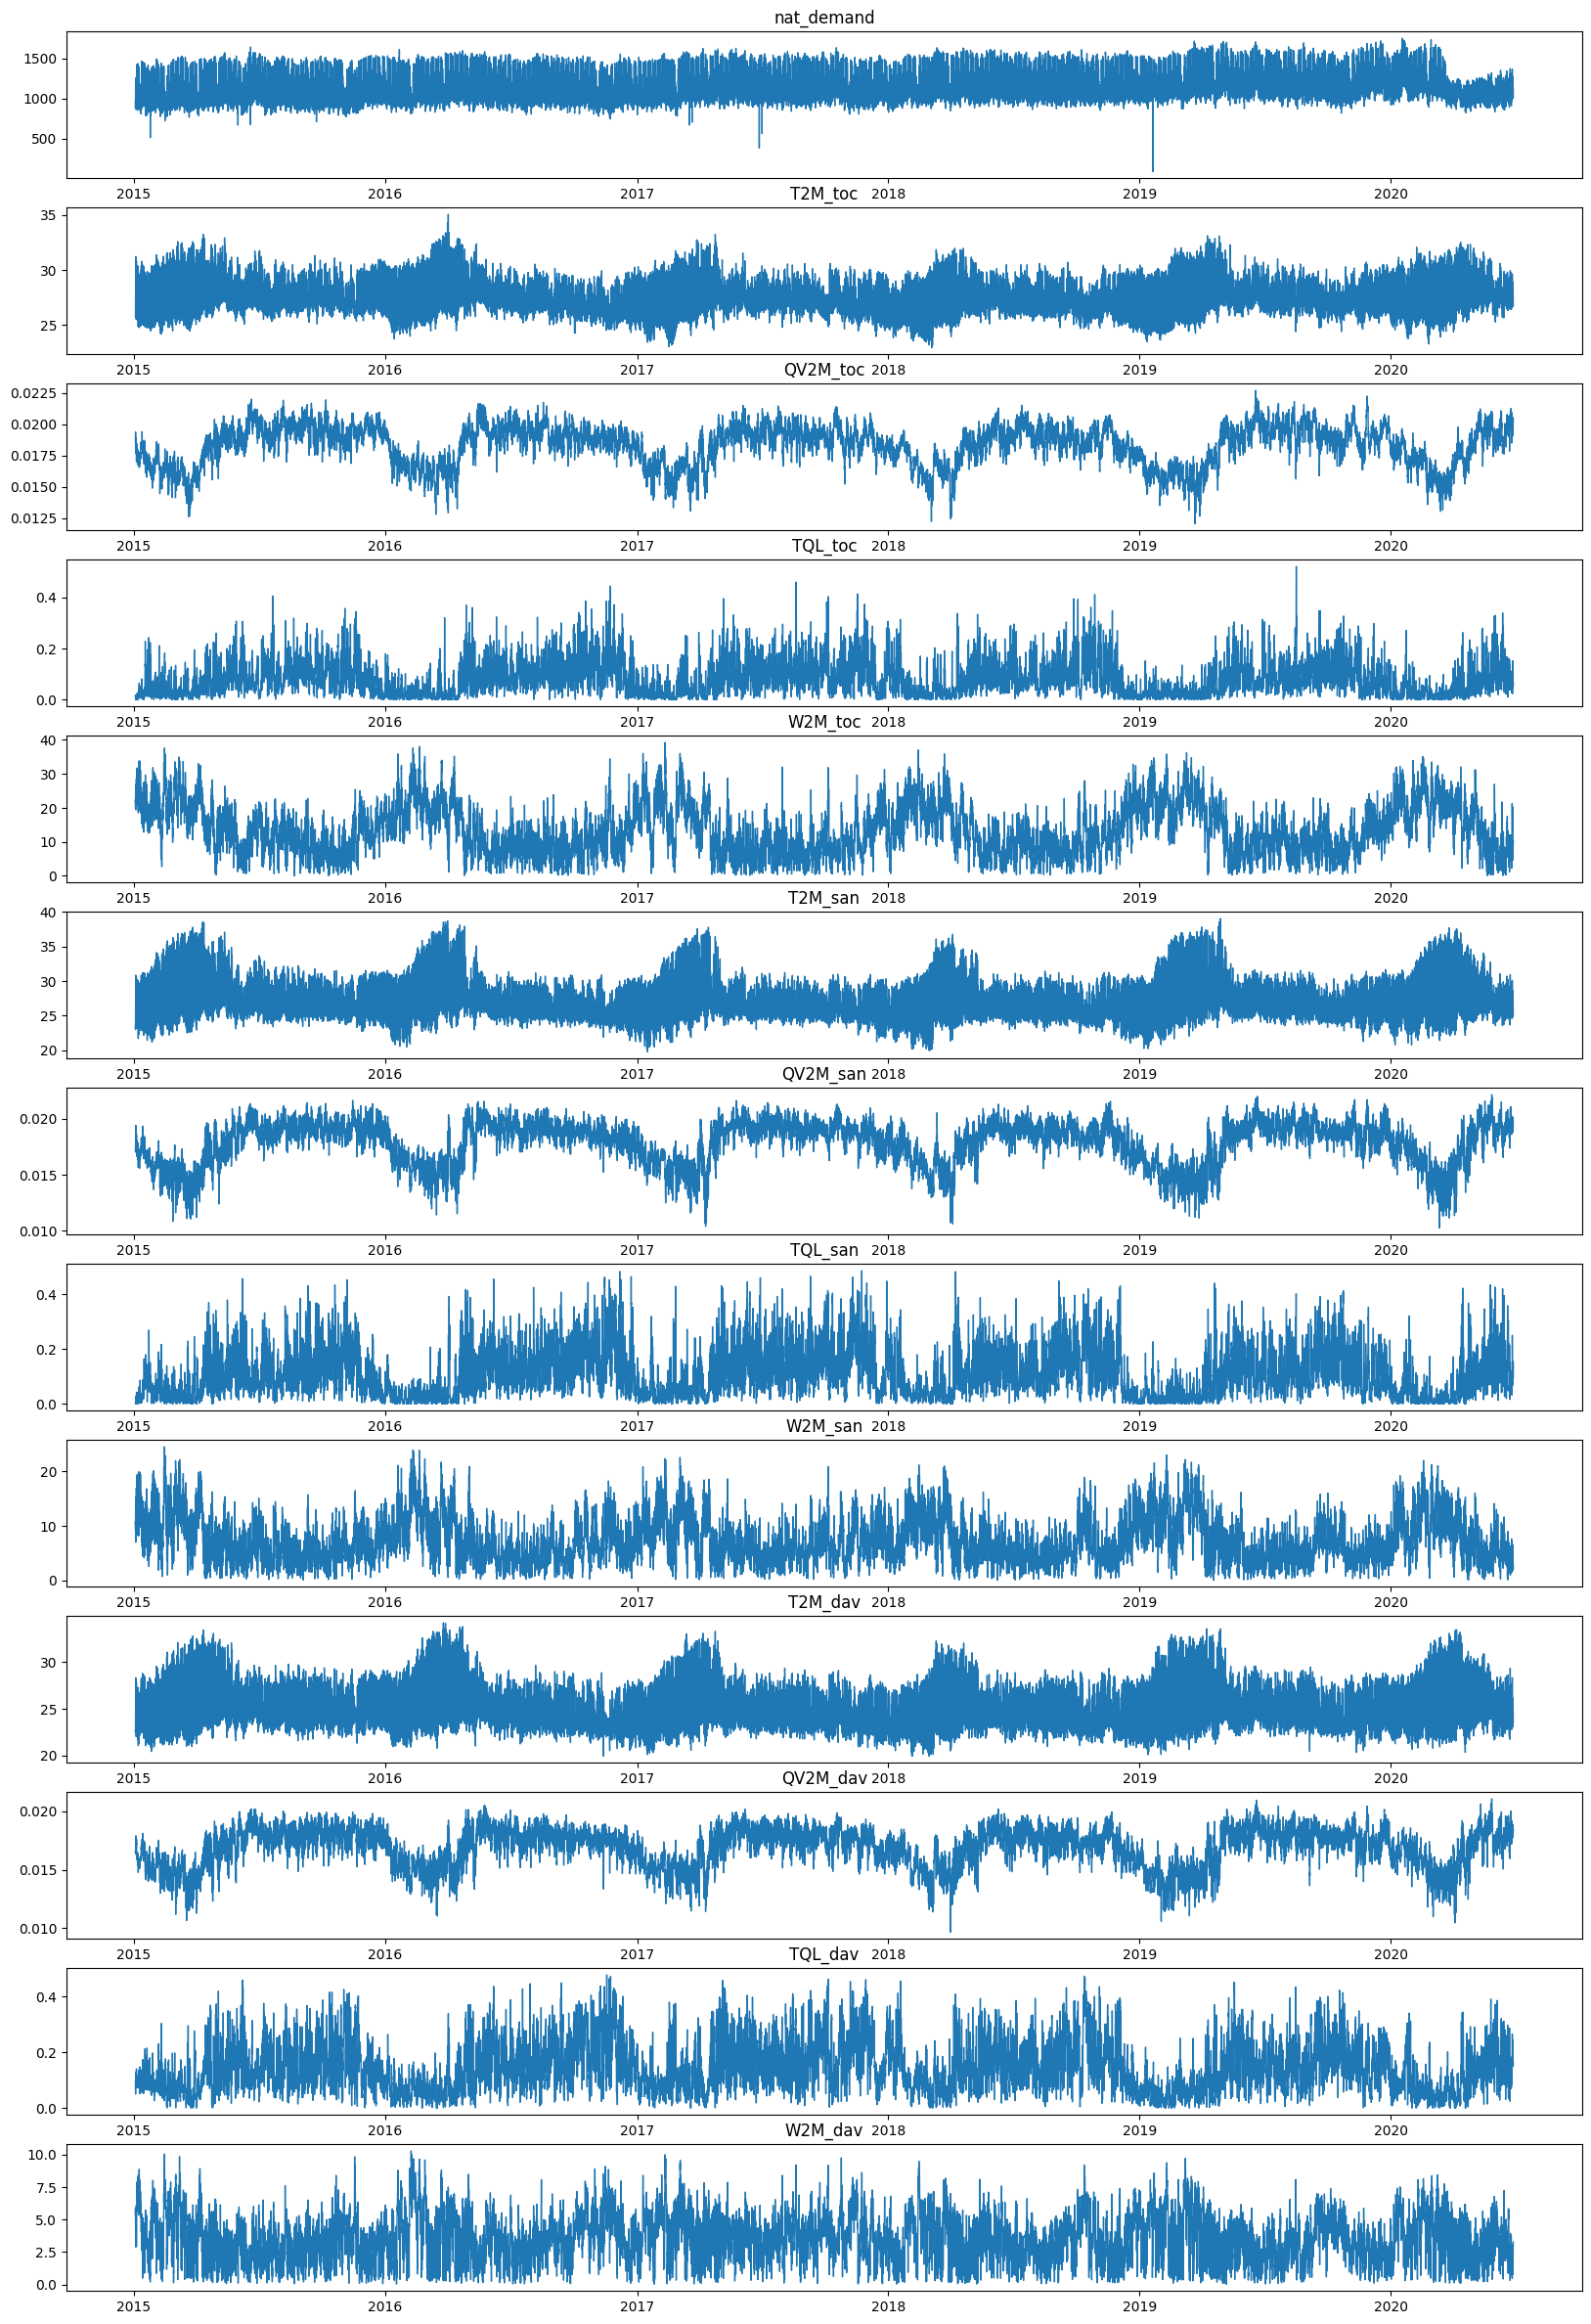

In [16]:
#Визуализируем временные ряды
fig, axes = plt.subplots(nrows=13,ncols=1,figsize=(20,30))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data,linewidth=1)
    ax.set_title(df.columns[i])

In [17]:
#Функция теста Адфулера на стационарность
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [7]:
#Разделение датасета на обучающий и тестовый
train = df[:int(0.8*len(df))]
test = df[int(0.8*len(df)):]

In [19]:
#Проверка на стационарность
for name, column in train.items():
    adfuller_test(column, name=column.name)
    print('\n')
#Как можно видеть все ряды стационарные на уровне значимости 0.05

    Augmented Dickey-Fuller Test on "nat_demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.1887
 No. Lags Chosen       = 54
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "T2M_toc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.2172
 No. Lags Chosen       = 53
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "QV2M_toc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

In [20]:
#Создаем модель
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(train)

c:\Users\maga-\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [36]:
#Ищем лучший порядок модели
orders = [3,6,12,24,48,96,168,252,336]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]

for i,j in enumerate(zip(*results)):
    print('Lag Order =', orders[i])
    print('AIC : ', j[0], "*" if i == best_pos[0] else "")
    print('BIC : ', j[1], "*" if i == best_pos[1] else "")
    print('FPE : ', j[2], "*" if i == best_pos[2] else "")
    print('HQIC: ', j[3], "*" if i == best_pos[3] else "", '\n')

Lag Order = 3
AIC :  -89.17427998075127 
BIC :  -89.05851319614017 
FPE :  1.8711227575184536e-39 
HQIC:  -89.13756777829276  

Lag Order = 6
AIC :  -89.58837026785744 
BIC :  -89.35971510654782 
FPE :  1.2367023403583835e-39 
HQIC:  -89.51585840331695  

Lag Order = 12
AIC :  -90.28577553702202 
BIC :  -89.83129692205071 
FPE :  6.157240915418026e-40 
HQIC:  -90.1416487494877  

Lag Order = 24
AIC :  -92.59495045767503 
BIC :  -91.68863803896085 
FPE :  6.11682422024942e-41 
HQIC:  -92.30753139612544  

Lag Order = 48
AIC :  -93.69633457688252 
BIC :  -91.88560620126496 *
FPE :  2.0333641515811875e-41 
HQIC:  -93.12208099322868 * 

Lag Order = 96
AIC :  -93.90357632839098 
BIC :  -90.28101651771446 
FPE :  1.6531990960024038e-41 
HQIC:  -92.75465170375587  

Lag Order = 168
AIC :  -93.91979525960951 *
BIC :  -87.57196314738027 
FPE :  1.6287448750390114e-41 *
HQIC:  -91.90635004393212  

Lag Order = 252
AIC :  -93.71930213556558 
BIC :  -84.18051560000589 
FPE :  1.9980832340823003e-4

In [100]:
#Обучем модель с лучшим порядком
model_fitted = model.fit(168)
model_fitted.summary()

c:\Users\maga-\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1502: RuntimeWarning: invalid value encountered in matmul
  return np.kron(np.linalg.inv(z.T @ z), self.sigma_u)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Dec, 2023
Time:                     15:10:17
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                   -87.5720
Nobs:                     38270.0    HQIC:                  -91.9064
Log likelihood:       1.11962e+06    FPE:                1.62874e-41
AIC:                     -93.9198    Det(Omega_mle):     7.91361e-42
--------------------------------------------------------------------
Results for equation nat_demand
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  13.529448         9.129658            1.482           0.138
L1.nat_demand           1.193474         0.005230          228.192           0.000
L1.T2M_toc              8.622184         1.8917

In [8]:
#Различные функции для создания датасетов из датафрема
def create_test_dataset(test,in_seq,for_len,step):
    testX = []
    testY = []
    for i in range(0,len(test)-for_len-in_seq,step):
        testX.append(test[i:(i+in_seq)].to_numpy())
        testY.append(test[(i+in_seq):(i+in_seq+for_len)].to_numpy())
    return testX, testY

def create_dataset(train,in_seq,for_len,step):
    trainX = []
    trainY = []
    for i in range(0,len(train)-for_len-in_seq,step):
        trainX.append(train[i:(i+in_seq)].to_numpy())
        trainY.append(train[(i+in_seq):(i+in_seq+for_len)].to_numpy())
    return trainX, trainY

def create_dataset_generator(train,in_seq,for_len,step):
    for i in range(0,len(train)-for_len-in_seq,step):
        trainX = train[i:(i+in_seq)].to_numpy()
        trainY = train[(i+in_seq):(i+in_seq+for_len)].to_numpy()
        yield trainX, trainY

In [105]:
#Создаем тестовый датасет (состоит из прогнозов на 24 часа, по предудущей недели)
testX, testY = create_test_dataset(test,168,24,24)

In [112]:
#Проверяем оставшуюся последовательную кореляцию
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

nat_demand : 2.06
T2M_toc : 2.0
QV2M_toc : 2.0
TQL_toc : 2.0
W2M_toc : 2.0
T2M_san : 2.0
QV2M_san : 2.0
TQL_san : 2.0
W2M_san : 2.0
T2M_dav : 2.0
QV2M_dav : 2.0
TQL_dav : 2.0
W2M_dav : 2.0


In [57]:
#Функции для вычисления метрик
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(name,true, pred):
    print(f"Metrics for {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def print_metrics(columns_name,true,pred):
    for n in range(len(columns_name)):
        name = columns_name[n]
        trueY = true[:,:,n]
        predY = pred[:,:,n]
        validate(name,trueY,predY)

In [106]:
#Делаем предсказания для обучающего датасета
predY = []

for i in testX:
    predY.append(model_fitted.forecast(y=i,steps=24))

In [ ]:
#Тут понятно
predY = np.array(predY)
testY = np.array(testY)

In [108]:
#Вычисляем метрики
print_metrics(df.columns,testY,predY)

Metrics for nat_demand
MSE: 5093.681778996131
RMSE: 71.37003418099314
MAE: 50.342833439260424
MAPE: 4.197705541298988
R2: 0.5802143808774382 

Metrics for T2M_toc
MSE: 0.16973387277978205
RMSE: 0.4119877095008807
MAE: 0.3069682729607583
MAPE: 1.1172090771260474
R2: 0.7309729693738124 

Metrics for QV2M_toc
MSE: 2.9474491657609913e-07
RMSE: 0.0005429041504502421
MAE: 0.0004062541553734626
MAPE: 2.20150734329965
R2: 0.877704130522115 

Metrics for TQL_toc
MSE: 0.001876454710390182
RMSE: 0.04331806448111668
MAE: 0.03181425358704532
MAPE: inf
R2: 0.41689223238670703 

Metrics for W2M_toc
MSE: 11.459624886942807
RMSE: 3.385206771667398
MAE: 2.537710164706018
MAPE: 33.74305494578014
R2: 0.7625914468465798 

Metrics for T2M_san
MSE: 0.42702737943154534
RMSE: 0.6534733196019141
MAE: 0.4934742220572245
MAPE: 1.8502162372550701
R2: 0.6916610318125507 

Metrics for QV2M_san
MSE: 3.338744381734165e-07
RMSE: 0.000577818689705877
MAE: 0.0004232677361304146
MAPE: 2.378536854883858
R2: 0.8858572831803

C:\Users\maga-\AppData\Local\Temp\ipykernel_4468\3987795003.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


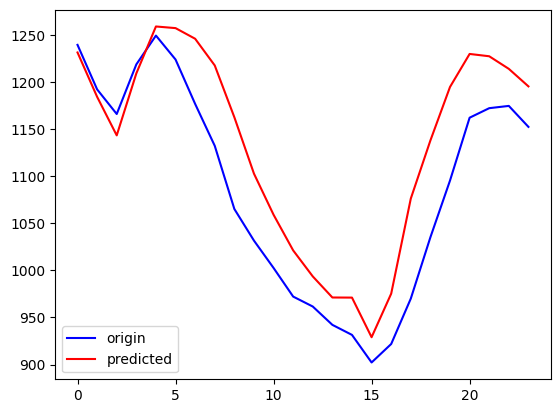

In [113]:
#Визуализация предсказания на 24 часа
plt.plot(testY[100,:,0],color="b",label="origin")
plt.plot(predY[100,:,0],color="r",label="predicted")
plt.legend()

In [121]:
#Визуализация для всего тестового датасета
plt.figure(figsize=(20,5))
plt.plot(testY[:,:,0].flatten(),color="b",label="origin")
plt.plot(predY[:,:,0].flatten(),color="r",label="predicted")
plt.legend()


In [ ]:
#Теперь используем lstm для предсказания нагрузки на следующие 24 часа по нагрузке и погоде за предыдущую неделю

In [154]:
#Нормализуем обучающие и тестовые данные

M = train.mean()
S = train.std()

trian_normal = (train - M)/S
test_normal = (test-M)/S

In [155]:
#Функция для создания датасета для нейросети
def create_dataset_lstm(train,in_seq,for_len,step,col="nat_demand"):
    trainX = []
    trainY = []
    for i in range(0,len(train)-for_len-in_seq,step):
        trainX.append(train[i:(i+in_seq)].to_numpy())
        trainY.append(train[(i+in_seq):(i+in_seq+for_len)][col].to_numpy())
    return trainX, trainY

In [156]:
#Создание обучающего датасета
trainX, trainY = create_dataset_lstm(trian_normal,168,24,1)

In [157]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense


In [158]:
#Определение модели
def build_model(optimizer="adam", npas = 168, icol = 13, out = 24):
    grid_model = Sequential()
    grid_model.add(LSTM(20 + npas,input_shape=(npas,icol)))
    #grid_model.add(LSTM(20 + npas,return_sequences=True,input_shape=(npas,icol)))
    #grid_model.add(LSTM(20 + npas))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(out))

    grid_model.compile(loss = 'huber_loss',optimizer = optimizer)
    return grid_model



In [159]:
#Создание модели
model = KerasRegressor(model=build_model,verbose=1)

In [160]:
trainX = np.array(trainX)
trainY = np.array(trainY)

In [161]:
#Обучение модели
model_fitted = model.fit(trainX,trainY,epochs=5)

Epoch 1/5
1196/1196 [==============================] - 609s 508ms/step - loss: 0.0905
Epoch 2/5
1196/1196 [==============================] - 594s 497ms/step - loss: 0.0571
Epoch 3/5
1196/1196 [==============================] - 592s 495ms/step - loss: 0.0447
Epoch 4/5
1196/1196 [==============================] - 595s 497ms/step - loss: 0.0360
Epoch 5/5
1196/1196 [==============================] - 594s 496ms/step - loss: 0.0320


In [162]:
#Функция для создания тестового датасета
def create_test_dataset_lstm(test,in_seq,for_len,step,col="nat_demand"):
    testX = []
    testY = []
    for i in range(0,len(test)-for_len-in_seq,step):
        testX.append(test[i:(i+in_seq)].to_numpy())
        testY.append(test[(i+in_seq):(i+in_seq+for_len)][col].to_numpy())
    return testX, testY

In [163]:
#Создание тестового датасета
testX, testY = create_test_dataset_lstm(test_normal,168,24,24)

In [164]:
testX = np.array(testX)
testY = np.array(testY)

In [165]:
#Получение предсказаний для тестового датасета
predY = model_fitted.predict(testX)

13/13 [==============================] - 2s 106ms/step


In [166]:
predY = np.array(predY)

In [167]:
#Денормализуем предсказания
predY = predY*S[0]
predY = predY+M[0]

C:\Users\maga-\AppData\Local\Temp\ipykernel_5652\2356723447.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predY = predY*S[0]
C:\Users\maga-\AppData\Local\Temp\ipykernel_5652\2356723447.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predY = predY+M[0]


In [168]:
testY = testY*S[0]
testY = testY+M[0]

C:\Users\maga-\AppData\Local\Temp\ipykernel_5652\340023199.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  testY = testY*S[0]
C:\Users\maga-\AppData\Local\Temp\ipykernel_5652\340023199.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  testY = testY+M[0]


In [169]:
#Вычисление метрик
validate("nat_demand",testY,predY)

Metrics for nat_demand
MSE: 8549.153264012386
RMSE: 92.4616313073287
MAE: 56.40162720746404
MAPE: 4.710516421913444
R2: 0.5663326710786255 



In [170]:
#Визуализация предсказания для одного дня
plt.plot(testY[100,:],color="b",label="origin")
plt.plot(predY[100,:],color="r",label="predicted")
plt.legend()

In [171]:
#Визуализация предсказания для всего тетововго датасета
plt.figure(figsize=(20,5))
plt.plot(testY[:,:].flatten(),color="b",label="origin")
plt.plot(predY[:,:].flatten(),color="r",label="predicted")
plt.legend()

In [ ]:
#Заключение
#Как можно видеть оба метода предсказания временного ряда показали лишь частичную способность предсказать значения нагрузки на следующий день
#У обоих рядов средняя абсолютная ошибка в процентах была примерно равна 4%, а R2 примерно равно 0.6.

#У тестового ряда в конце есть аномалия (снижается нагрузка на сеть)
#Подобные аномалии отсутсвуют в обучающем ряде, но при этом VAR смогла описать эту аномалию, а нейросеть нет.
#При этом нейросеть обучалась намного дольше.
#Возможно причиной неудачи нейросети являетя малое количество эпох обучения (5), и для качественной работы нейросети требуется более длительное обучение.


#Можно сделать вывод, что при отсуствии времении и достаточных вычислительных ресурсов, классические алгоритмы имеют преймущество перед нейросетями.
#Но из опыта использования нейросетей мы знаем, что нейросети имеют большую апроксимирующую способность, пожтому при достаточно большом количестве имеющегося времени 
#и вычислительных ресурсов, нейросеть покажет более лучшие результаты, чем класический алгоритм VAR.